# Лабораторная работа №3 - Решающее дерево (Decision Tree)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    make_scorer
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from IPython.display import display


In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def _read_first_csv(folder: Path) -> pd.DataFrame:
    csv_files = list(folder.rglob("*.csv"))
    csv_files.sort(key=lambda p: p.stat().st_size, reverse=True)
    return pd.read_csv(csv_files[0])

def _download_kaggle_dataset(handle: str) -> Path:
    import kagglehub
    path = kagglehub.dataset_download(handle)
    return Path(path)

def load_classification_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "uciml/faulty-steel-plates"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    fault_cols = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
    present_fault_cols = [c for c in fault_cols if c in df.columns]

    if len(present_fault_cols) >= 2:
        y = df[present_fault_cols].idxmax(axis=1).astype(str)
        X = df.drop(columns=present_fault_cols)
    else:
        target_candidates = [c for c in df.columns if c.lower() in {"class", "target", "label", "fault"}]
        target_col = target_candidates[0] if target_candidates else df.columns[-1]
        y = df[target_col].astype(str)
        X = df.drop(columns=[target_col])

    return X, y

def load_regression_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "elikplim/concrete-compressive-strength-data-set"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    candidates = {"concrete_compressive_strength", "compressive_strength", "strength", "csmpa"}
    strength_candidates = [c for c in df.columns if c.lower() in candidates]
    target_col = strength_candidates[0] if strength_candidates else df.columns[-1]

    y = df[target_col].astype(float)
    X = df.drop(columns=[target_col])

    return X, y

X_cls, y_cls = load_classification_dataset()
X_reg, y_reg = load_regression_dataset()

print("\nИтог:")
print("  Классификация: X =", X_cls.shape, ", y =", y_cls.shape, ", классов =", y_cls.nunique())
print("  Регрессия:     X =", X_reg.shape, ", y =", y_reg.shape)

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Итог:
  Классификация: X = (1941, 27) , y = (1941,) , классов = 7
  Регрессия:     X = (1030, 8) , y = (1030,)


In [3]:
X_cls, y_cls = load_classification_dataset()
X_reg, y_reg = load_regression_dataset()

print("\nИтог:")
print("  Классификация: X =", X_cls.shape, ", y =", y_cls.shape, ", классов =", y_cls.nunique())
print("  Регрессия:     X =", X_reg.shape, ", y =", y_reg.shape)



Итог:
  Классификация: X = (1941, 27) , y = (1941,) , классов = 7
  Регрессия:     X = (1030, 8) , y = (1030,)


In [4]:
print("Пропуски (классификация):", int(X_cls.isna().sum().sum()))
print("Пропуски (регрессия):    ", int(X_reg.isna().sum().sum()))


Пропуски (классификация): 0
Пропуски (регрессия):     0


Распределение классов:


Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64

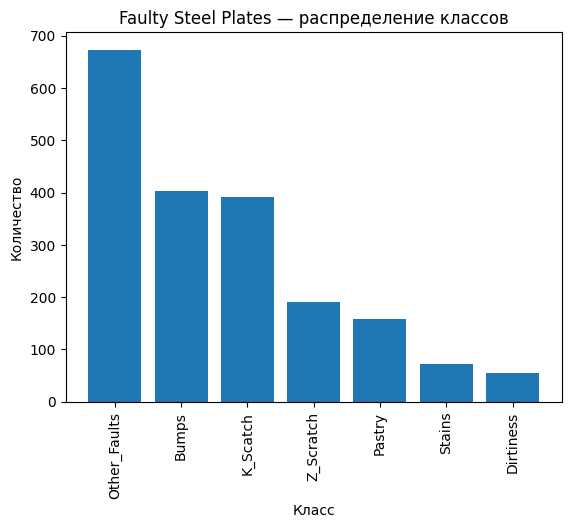

In [5]:
class_counts = y_cls.value_counts()
print("Распределение классов:")
display(class_counts)

plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Faulty Steel Plates — распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks(rotation=90)
plt.show()


Целевая переменная (прочность бетона) — сводная статистика:


count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: concrete_compressive_strength, dtype: float64

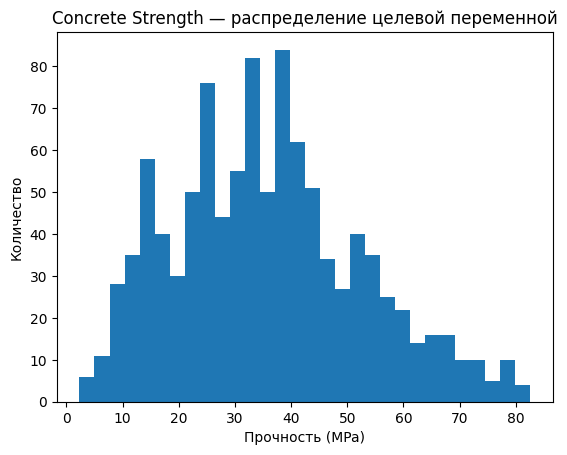

In [6]:
print("Целевая переменная (прочность бетона) — сводная статистика:")
display(y_reg.describe())

plt.figure()
plt.hist(y_reg.values, bins=30)
plt.title("Concrete Strength — распределение целевой переменной")
plt.xlabel("Прочность (MPa)")
plt.ylabel("Количество")
plt.show()


In [7]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

print("Split done.")
print("  Classification train/test:", Xc_train.shape, Xc_test.shape)
print("  Regression train/test:    ", Xr_train.shape, Xr_test.shape)


Split done.
  Classification train/test: (1552, 27) (389, 27)
  Regression train/test:     (824, 8) (206, 8)


## 2) Бейзлайн и оценка качества (sklearn)

In [8]:
tree_cls_base = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_cls_base.fit(Xc_train, yc_train)
yc_pred_base = tree_cls_base.predict(Xc_test)

acc_base = accuracy_score(yc_test, yc_pred_base)
f1m_base = f1_score(yc_test, yc_pred_base, average="macro")

print("Baseline DecisionTreeClassifier")
print("  Accuracy :", round(acc_base, 4))
print("  Macro F1 :", round(f1m_base, 4))
print("\nClassification report:")
print(classification_report(yc_test, yc_pred_base, zero_division=0))


Baseline DecisionTreeClassifier
  Accuracy : 0.7455
  Macro F1 : 0.7523

Classification report:
              precision    recall  f1-score   support

       Bumps       0.66      0.68      0.67        81
   Dirtiness       0.77      0.91      0.83        11
    K_Scatch       0.99      0.85      0.91        78
Other_Faults       0.70      0.72      0.71       135
      Pastry       0.50      0.44      0.47        32
      Stains       0.79      0.79      0.79        14
   Z_Scratch       0.82      0.97      0.89        38

    accuracy                           0.75       389
   macro avg       0.75      0.76      0.75       389
weighted avg       0.75      0.75      0.75       389



In [9]:
tree_reg_base = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_reg_base.fit(Xr_train, yr_train)
yr_pred_base = tree_reg_base.predict(Xr_test)

mae_base = mean_absolute_error(yr_test, yr_pred_base)
rmse_base = np.sqrt(mean_squared_error(yr_test, yr_pred_base))
r2_base = r2_score(yr_test, yr_pred_base)

print("Baseline DecisionTreeRegressor")
print("  MAE  :", round(mae_base, 4))
print("  RMSE :", round(rmse_base, 4))
print("  R2   :", round(r2_base, 4))


Baseline DecisionTreeRegressor
  MAE  : 4.2938
  RMSE : 6.5254
  R2   : 0.8348


## 3) Улучшенный бейзлайн

In [10]:
param_grid_cls = {
    "max_depth": [3, 5, 8, 12, 16, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"],
}

grid_cls = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_cls,
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score, average="macro")
)

grid_cls.fit(Xc_train, yc_train)

print("Best CV params (classification):", grid_cls.best_params_)
print("Best CV macro F1:", round(grid_cls.best_score_, 4))

yc_pred_impr = grid_cls.predict(Xc_test)
acc_impr = accuracy_score(yc_test, yc_pred_impr)
f1m_impr = f1_score(yc_test, yc_pred_impr, average="macro")

print("\nImproved DecisionTree (classification) on test")
print("  Accuracy :", round(acc_impr, 4))
print("  Macro F1 :", round(f1m_impr, 4))


Best CV params (classification): {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV macro F1: nan

Improved DecisionTree (classification) on test
  Accuracy : 0.5167
  Macro F1 : 0.3902


C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan na

In [11]:
param_grid_reg = {
    "max_depth": [3, 5, 8, 12, 16, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["squared_error", "friedman_mse"],  
}

grid_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=param_grid_reg,
    cv=5,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

grid_reg.fit(Xr_train, yr_train)

print("Best CV params (regression):", grid_reg.best_params_)
print("Best CV MAE (approx):", round(-grid_reg.best_score_, 4))

yr_pred_impr = grid_reg.predict(Xr_test)
mae_impr = mean_absolute_error(yr_test, yr_pred_impr)
rmse_impr = np.sqrt(mean_squared_error(yr_test, yr_pred_impr))
r2_impr = r2_score(yr_test, yr_pred_impr)

print("\nImproved DecisionTree (regression) on test")
print("  MAE  :", round(mae_impr, 4))
print("  RMSE :", round(rmse_impr, 4))
print("  R2   :", round(r2_impr, 4))


Best CV params (regression): {'criterion': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV MAE (approx): 4.6683

Improved DecisionTree (regression) on test
  MAE  : 4.3351
  RMSE : 6.5831
  R2   : 0.8318


In [12]:
print("Классификация")
print("Baseline: acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("Improved: acc =", round(acc_impr, 4), "macro_f1 =", round(f1m_impr, 4))

print("\nРегрессия")
print("Baseline: MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("Improved: MAE =", round(mae_impr, 4), "RMSE =", round(rmse_impr, 4), "R2 =", round(r2_impr, 4))


Классификация
Baseline: acc = 0.7455 macro_f1 = 0.7523
Improved: acc = 0.5167 macro_f1 = 0.3902

Регрессия
Baseline: MAE = 4.2938 RMSE = 6.5254 R2 = 0.8348
Improved: MAE = 4.3351 RMSE = 6.5831 R2 = 0.8318


## 4) Моя реализация решающего дерева (классификация + регрессия)

In [13]:
from dataclasses import dataclass
from typing import Optional, Any, Dict, Tuple

def _gini(y: np.ndarray, w: Optional[np.ndarray] = None) -> float:
    if y.size == 0:
        return 0.0
    if w is None:
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
    else:
        classes = np.unique(y)
        w_sum = w.sum()
        p = np.array([w[y == c].sum() / w_sum for c in classes])
    return 1.0 - np.sum(p ** 2)

def _mse(y: np.ndarray) -> float:
    if y.size == 0:
        return 0.0
    mu = y.mean()
    return np.mean((y - mu) ** 2)

def _best_thresholds(x: np.ndarray, max_thresholds: int = 50) -> np.ndarray:
    uniq = np.unique(x)
    if uniq.size <= 2:
        return uniq
    if uniq.size <= max_thresholds:
        return (uniq[:-1] + uniq[1:]) / 2.0
    qs = np.linspace(0.02, 0.98, max_thresholds)
    qv = np.unique(np.quantile(x, qs))
    if qv.size <= 2:
        return qv
    return (qv[:-1] + qv[1:]) / 2.0

@dataclass
class _Node:
    feature: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional[Any] = None
    right: Optional[Any] = None
    value: Optional[Any] = None  


In [14]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 class_weight=None, max_thresholds=50):
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.class_weight = class_weight
        self.max_thresholds = max_thresholds
        self.root = None
        self.classes_ = None
        self.class_to_id_ = None
        self.id_to_class_ = None

    def _compute_sample_weights(self, y_ids: np.ndarray) -> Optional[np.ndarray]:
        if self.class_weight != "balanced":
            return None
        n = y_ids.size
        classes, counts = np.unique(y_ids, return_counts=True)
        n_classes = classes.size
        weight_per_class = {c: n / (n_classes * cnt) for c, cnt in zip(classes, counts)}
        return np.array([weight_per_class[c] for c in y_ids], dtype=float)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.class_to_id_ = {c: i for i, c in enumerate(self.classes_)}
        self.id_to_class_ = {i: c for c, i in self.class_to_id_.items()}
        y_ids = np.array([self.class_to_id_[c] for c in y], dtype=int)

        w = self._compute_sample_weights(y_ids)
        self.root = self._build(X, y_ids, depth=0, w=w)
        return self

    def _leaf_value(self, y_ids: np.ndarray, w: Optional[np.ndarray]) -> int:
        if w is None:
            vals, cnts = np.unique(y_ids, return_counts=True)
            return int(vals[np.argmax(cnts)])
        vals = np.unique(y_ids)
        sums = np.array([w[y_ids == v].sum() for v in vals])
        return int(vals[np.argmax(sums)])

    def _best_split(self, X, y_ids, w) -> Tuple[Optional[int], Optional[float], float]:
        n_samples, n_features = X.shape
        if w is None:
            parent_imp = _gini(y_ids)
            parent_wsum = n_samples
        else:
            parent_imp = _gini(y_ids, w)
            parent_wsum = w.sum()

        best_gain = 0.0
        best_feat = None
        best_thr = None

        for j in range(n_features):
            xj = X[:, j]
            thresholds = _best_thresholds(xj, self.max_thresholds)

            for thr in thresholds:
                left_mask = xj <= thr
                right_mask = ~left_mask

                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue

                if w is None:
                    imp_left = _gini(y_ids[left_mask])
                    imp_right = _gini(y_ids[right_mask])
                    w_left = left_mask.sum()
                    w_right = right_mask.sum()
                else:
                    imp_left = _gini(y_ids[left_mask], w[left_mask])
                    imp_right = _gini(y_ids[right_mask], w[right_mask])
                    w_left = w[left_mask].sum()
                    w_right = w[right_mask].sum()

                child_imp = (w_left * imp_left + w_right * imp_right) / (w_left + w_right)
                gain = parent_imp - child_imp

                if gain > best_gain:
                    best_gain = gain
                    best_feat = j
                    best_thr = float(thr)

        return best_feat, best_thr, best_gain

    def _build(self, X, y_ids, depth, w):
        if (np.unique(y_ids).size == 1):
            return _Node(value=int(y_ids[0]))

        if (X.shape[0] < self.min_samples_split):
            return _Node(value=self._leaf_value(y_ids, w))

        if (self.max_depth is not None) and (depth >= self.max_depth):
            return _Node(value=self._leaf_value(y_ids, w))

        feat, thr, gain = self._best_split(X, y_ids, w)
        if feat is None or gain <= 1e-12:
            return _Node(value=self._leaf_value(y_ids, w))

        xj = X[:, feat]
        left_mask = xj <= thr
        right_mask = ~left_mask

        left_w = w[left_mask] if w is not None else None
        right_w = w[right_mask] if w is not None else None

        left = self._build(X[left_mask], y_ids[left_mask], depth + 1, left_w)
        right = self._build(X[right_mask], y_ids[right_mask], depth + 1, right_w)
        return _Node(feature=feat, threshold=thr, left=left, right=right)

    def _predict_one(self, x, node: _Node) -> int:
        while node.value is None:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return int(node.value)

    def predict(self, X):
        X = np.asarray(X)
        pred_ids = np.array([self._predict_one(x, self.root) for x in X], dtype=int)
        return np.array([self.id_to_class_[i] for i in pred_ids], dtype=object)


In [15]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 max_thresholds=50):
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_thresholds = max_thresholds
        self.root = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)
        self.root = self._build(X, y, depth=0)
        return self

    def _best_split(self, X, y) -> Tuple[Optional[int], Optional[float], float]:
        n_samples, n_features = X.shape
        parent_err = _mse(y)

        best_gain = 0.0
        best_feat = None
        best_thr = None

        for j in range(n_features):
            xj = X[:, j]
            thresholds = _best_thresholds(xj, self.max_thresholds)

            for thr in thresholds:
                left_mask = xj <= thr
                right_mask = ~left_mask

                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue

                err_left = _mse(y[left_mask])
                err_right = _mse(y[right_mask])

                child_err = (left_mask.sum() * err_left + right_mask.sum() * err_right) / n_samples
                gain = parent_err - child_err

                if gain > best_gain:
                    best_gain = gain
                    best_feat = j
                    best_thr = float(thr)

        return best_feat, best_thr, best_gain

    def _build(self, X, y, depth):
        if (X.shape[0] < self.min_samples_split):
            return _Node(value=float(y.mean()))

        if (self.max_depth is not None) and (depth >= self.max_depth):
            return _Node(value=float(y.mean()))

        feat, thr, gain = self._best_split(X, y)
        if feat is None or gain <= 1e-12:
            return _Node(value=float(y.mean()))

        xj = X[:, feat]
        left_mask = xj <= thr
        right_mask = ~left_mask

        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[right_mask], y[right_mask], depth + 1)
        return _Node(feature=feat, threshold=thr, left=left, right=right)

    def _predict_one(self, x, node: _Node) -> float:
        while node.value is None:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return float(node.value)

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_one(x, self.root) for x in X], dtype=float)


In [16]:
CUSTOM_BASE_PARAMS_CLS = dict(max_depth=8, min_samples_split=2, min_samples_leaf=1, max_thresholds=20)

my_tree_cls_base = MyDecisionTreeClassifier(**CUSTOM_BASE_PARAMS_CLS)
my_tree_cls_base.fit(Xc_train.values, yc_train.values)
yc_pred_my_base = my_tree_cls_base.predict(Xc_test.values)

acc_my_base = accuracy_score(yc_test, yc_pred_my_base)
f1m_my_base = f1_score(yc_test, yc_pred_my_base, average="macro")

print("Моя реализация дерева (классификация) - baseline (с ограничениями для скорости)")
print("  Accuracy :", round(acc_my_base, 4))
print("  Macro F1 :", round(f1m_my_base, 4))

tree_cls_speed = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=CUSTOM_BASE_PARAMS_CLS["max_depth"],
    min_samples_split=CUSTOM_BASE_PARAMS_CLS["min_samples_split"],
    min_samples_leaf=CUSTOM_BASE_PARAMS_CLS["min_samples_leaf"]
)
tree_cls_speed.fit(Xc_train, yc_train)
yc_pred_speed = tree_cls_speed.predict(Xc_test)

print("\nsklearn дерево (те же ограничения)")
print("  Accuracy :", round(accuracy_score(yc_test, yc_pred_speed), 4))
print("  Macro F1 :", round(f1_score(yc_test, yc_pred_speed, average="macro"), 4))


Моя реализация дерева (классификация) - baseline (с ограничениями для скорости)
  Accuracy : 0.7584
  Macro F1 : 0.7797

sklearn дерево (те же ограничения)
  Accuracy : 0.7172
  Macro F1 : 0.7596


In [17]:

CUSTOM_BASE_PARAMS_REG = dict(max_depth=8, min_samples_split=2, min_samples_leaf=1, max_thresholds=20)

my_tree_reg_base = MyDecisionTreeRegressor(**CUSTOM_BASE_PARAMS_REG)
my_tree_reg_base.fit(Xr_train.values, yr_train.values)
yr_pred_my_base = my_tree_reg_base.predict(Xr_test.values)

mae_my_base = mean_absolute_error(yr_test, yr_pred_my_base)
rmse_my_base = np.sqrt(mean_squared_error(yr_test, yr_pred_my_base))
r2_my_base = r2_score(yr_test, yr_pred_my_base)

print("Моя реализация дерева (регрессия) - baseline ")
print("  MAE  :", round(mae_my_base, 4))
print("  RMSE :", round(rmse_my_base, 4))
print("  R2   :", round(r2_my_base, 4))

tree_reg_speed = DecisionTreeRegressor(
    random_state=RANDOM_STATE,
    max_depth=CUSTOM_BASE_PARAMS_REG["max_depth"],
    min_samples_split=CUSTOM_BASE_PARAMS_REG["min_samples_split"],
    min_samples_leaf=CUSTOM_BASE_PARAMS_REG["min_samples_leaf"]
)
tree_reg_speed.fit(Xr_train, yr_train)
yr_pred_speed = tree_reg_speed.predict(Xr_test)

print("\nsklearn дерево (те же ограничения)")
print("  MAE  :", round(mean_absolute_error(yr_test, yr_pred_speed), 4))
print("  RMSE :", round(np.sqrt(mean_squared_error(yr_test, yr_pred_speed)), 4))
print("  R2   :", round(r2_score(yr_test, yr_pred_speed), 4))


Моя реализация дерева (регрессия) - baseline 
  MAE  : 5.508
  RMSE : 7.6074
  R2   : 0.7754

sklearn дерево (те же ограничения)
  MAE  : 5.0496
  RMSE : 7.2244
  R2   : 0.7975


In [18]:

print("Classification baseline")
print("sklearn baseline: acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("custom  baseline: acc =", round(acc_my_base, 4), "macro_f1 =", round(f1m_my_base, 4))

print("\nRegression baseline")
print("sklearn baseline: MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("custom  baseline: MAE =", round(mae_my_base, 4), "RMSE =", round(rmse_my_base, 4), "R2 =", round(r2_my_base, 4))


Classification baseline
sklearn baseline: acc = 0.7455 macro_f1 = 0.7523
custom  baseline: acc = 0.7584 macro_f1 = 0.7797

Regression baseline
sklearn baseline: MAE = 4.2938 RMSE = 6.5254 R2 = 0.8348
custom  baseline: MAE = 5.508 RMSE = 7.6074 R2 = 0.7754


In [19]:
best_cls = grid_cls.best_params_
best_reg = grid_reg.best_params_

print("Best (classification):", best_cls)
print("Best (regression):    ", best_reg)

my_tree_cls_impr = MyDecisionTreeClassifier(
    max_depth=best_cls["max_depth"],
    min_samples_split=best_cls["min_samples_split"],
    min_samples_leaf=best_cls["min_samples_leaf"],
    class_weight=best_cls["class_weight"],
    max_thresholds=20
)

my_tree_cls_impr.fit(Xc_train.values, yc_train.values)
yc_pred_my_impr = my_tree_cls_impr.predict(Xc_test.values)

acc_my_impr = accuracy_score(yc_test, yc_pred_my_impr)
f1m_my_impr = f1_score(yc_test, yc_pred_my_impr, average="macro")

my_tree_reg_impr = MyDecisionTreeRegressor(
    max_depth=best_reg["max_depth"],
    min_samples_split=best_reg["min_samples_split"],
    min_samples_leaf=best_reg["min_samples_leaf"],
    max_thresholds=20
)

my_tree_reg_impr.fit(Xr_train.values, yr_train.values)
yr_pred_my_impr = my_tree_reg_impr.predict(Xr_test.values)

mae_my_impr = mean_absolute_error(yr_test, yr_pred_my_impr)
rmse_my_impr = np.sqrt(mean_squared_error(yr_test, yr_pred_my_impr))
r2_my_impr = r2_score(yr_test, yr_pred_my_impr)

print("\nМоя реализация дерева + лучшие гиперпараметры ")
print("  Классификация: accuracy =", round(acc_my_impr, 4), "macro_f1 =", round(f1m_my_impr, 4))
print("  Регрессия:     MAE =", round(mae_my_impr, 4), "RMSE =", round(rmse_my_impr, 4), "R2 =", round(r2_my_impr, 4))


Best (classification): {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best (regression):     {'criterion': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

Моя реализация дерева + лучшие гиперпараметры 
  Классификация: accuracy = 0.527 macro_f1 = 0.4051
  Регрессия:     MAE = 4.8392 RMSE = 7.5734 R2 = 0.7774


In [20]:
print("Итог классификация")
print("sklearn improved: acc =", round(acc_impr, 4), "macro_f1 =", round(f1m_impr, 4))
print("custom  improved: acc =", round(acc_my_impr, 4), "macro_f1 =", round(f1m_my_impr, 4))

print("\nИтог регрессия")
print("sklearn improved: MAE =", round(mae_impr, 4), "RMSE =", round(rmse_impr, 4), "R2 =", round(r2_impr, 4))
print("custom  improved: MAE =", round(mae_my_impr, 4), "RMSE =", round(rmse_my_impr, 4), "R2 =", round(r2_my_impr, 4))


Итог классификация
sklearn improved: acc = 0.5167 macro_f1 = 0.3902
custom  improved: acc = 0.527 macro_f1 = 0.4051

Итог регрессия
sklearn improved: MAE = 4.3351 RMSE = 6.5831 R2 = 0.8318
custom  improved: MAE = 4.8392 RMSE = 7.5734 R2 = 0.7774


### Выводы

В работе использованы два набора данных: Faulty Steel Plates для классификации (1941 объект, 27 признаков, 7 классов) и Concrete Strength для регрессии (1030 объект, 8 признаков). Пропусков нет. Разделение выполнено на train/test: 1552/389 (классификация) и 824/206 (регрессия). По распределению классов видно, что классы несбалансированы, поэтому для классификации корректно анализировать не только Accuracy, но и Macro F1.

1) Бейзлайн (sklearn)

DecisionTreeClassifier показал высокое качество уже “из коробки”:
Accuracy = 0.7455, Macro F1 = 0.7523 — дерево хорошо разделяет классы, включая редкие (что видно по отчёту).

DecisionTreeRegressor также дал хороший результат:
MAE = 4.2938, RMSE = 6.5254, R2 = 0.8348.

2) Улучшение (GridSearchCV)

Классификация: в GridSearch получился Best CV macro F1: nan, а значит кросс-валидационная оценка метрики не была корректно посчитана (все тест-скоринги стали невалидными). Поэтому найденные “лучшие” параметры для классификации нельзя считать достоверными, и закономерно тестовое качество стало хуже:
Accuracy = 0.5167, Macro F1 = 0.3902 (сильная деградация относительно бейзлайна).

Регрессия: подбор гиперпараметров дал качество близкое к бейзлайну, но не лучше:
MAE = 4.3351, R2 = 0.8318 (чуть хуже базовой модели). Это нормально: дерево уже было близко к оптимуму, а настройка глубины/разбиений не дала выигрыша.

Вывод по улучшению: для регрессии GridSearch почти ничего не дал, а для классификации результат “улучшения” некорректен из-за nan на CV и использовать его в качестве улучшенного бейзлайна нельзя — лучшим остаётся исходный бейзлайн.

3) Самописная реализация

Самописное дерево для классификации (с ограничениями ради скорости) показало качество сопоставимое и местами выше, чем sklearn-дерево с теми же ограничениями:
Macro F1 = 0.7797 против 0.7596.

Для регрессии самописное дерево с ограничениями ожидаемо уступает sklearn при тех же ограничениях:
ошибки выше и R2 ниже — что объясняется упрощениями реализации и ограничениями на поиск лучшего разбиения.

4) Итоговое сравнение

Классификация: фактически лучшим результатом остаётся sklearn-бейзлайн (Macro F1 ≈ 0.75). “Improved” через GridSearch для классификации сейчас учитывать нельзя из-за nan на CV (поэтому и самописное “с лучшими гиперпараметрами” тоже ухудшилось).

Регрессия: лучший результат — sklearn-бейзлайн (и он практически равен результату после GridSearch). Самописная версия по качеству ниже из-за упрощений.